In [5]:
import pandas as pd
import numpy as np
import joblib
from textblob import TextBlob
from detoxify import Detoxify
from sentence_transformers import SentenceTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Import insider terms 
with open('keyword_lists/insider_terms.txt', 'r', encoding='utf-8') as file:
    INSIDER_TERMS = [line.strip() for line in file]

# Import bad words
with open('keyword_lists/profanity_list.txt', 'r', encoding='utf-8') as file:
    BAD_WORDS = [line.strip() for line in file]

# Transformer class for Subjectivity feature 
class SubjectivityTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    # Gets subjectivity (0–1) for each text, returns as 2D numpy array
    def transform(self, X):
        return np.array([TextBlob(text).sentiment.subjectivity for text in X['text']]).reshape(-1, 1)
    
# Transformer class for Toxicity feature     
class ToxicityTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.model = Detoxify('original')

    def fit(self, X, y=None):
        return self

    # Gets toxicity score (0–1) for each text, returns as 2D numpy array
    def transform(self, X):
        return np.array([self.model.predict(text)['toxicity'] for text in X['text']]).reshape(-1, 1)

# Transformer class for Profanity feature  
class ProfanityTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, bad_words=None):
        self.bad_words = bad_words

    def fit(self, X, y=None):
        return self

    # Checks for presence of any profanity for each text (0 or 1),
    # returns as 2D numpy array
    def transform(self, X):
        self.bad_words = BAD_WORDS
        result = []
        for text in X['text'].str.lower():
            words = text.split()
            result.append(int(any(word in self.bad_words for word in words)))
        return np.array(result).reshape(-1, 1)

# Transformer class for MiniLM feature 
class MiniLMTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.model = SentenceTransformer('all-MiniLM-L6-v2')

    def fit(self, X, y=None):
        return self

    # Encodes each text with MiniLM embeddings, returns as 2D numpy array
    def transform(self, X):
        return self.model.encode(X['text'].tolist(), convert_to_numpy=True)
    
# Transformer class for Insider Terms feature 
class InsiderTermsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, terms=None):
        self.terms = terms
        
    def fit(self, X, y=None):
        return self

    # Checks for presence of any insider terms for each text (0 or 1),
    # returns as 2D numpy array
    def transform(self, X):
        self.terms = INSIDER_TERMS
        texts = X['text'].str.lower().tolist()
        features = []

        for text in texts:
            features.append([int(term in text) for term in self.terms])

        return np.array(features)

def check_feature_correlations(df):
    """
    Takes in dataframe with data, calculates and prints out correlation table 
    between features evaluated on 0-1 scale
    """
    
    # Build dataframe with features
    features_df = pd.DataFrame({
        'profanity': ProfanityTransformer().fit_transform(df).ravel(),
        'subjectivity': SubjectivityTransformer().fit_transform(df).ravel(),
        'toxicity': ToxicityTransformer().fit_transform(df).ravel(),
        'insider_terms': InsiderTermsTransformer().fit_transform(df).max(axis=1)
    })

    
    print("Profanity unique values:", np.unique(features_df['profanity']))
    print("Profanity variance:", np.var(features_df['profanity']))


    print("\n[Feature Correlation Matrix]\n")
    print(features_df.corr())


def check_all(df, target_col='extreme'):
    """
    Uses logistic regression to assess feature importance against a binary target.
    Includes scalar features, TF-IDF mean, and MiniLM mean.
    """
    # Step 1: Scalar features
    features_df = pd.DataFrame({
        'profanity': ProfanityTransformer().fit_transform(df).ravel(),
        'subjectivity': SubjectivityTransformer().fit_transform(df).ravel(),
        'toxicity': ToxicityTransformer().fit_transform(df).ravel(),
        'insider_terms': InsiderTermsTransformer().fit_transform(df).max(axis=1),
    })

    # Step 2: TF-IDF (mean-reduced)
    tfidf_vec = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
    tfidf_matrix = tfidf_vec.fit_transform(df['text'])
    features_df['tfidf_mean'] = tfidf_matrix.mean(axis=1).A1

    # Step 3: MiniLM embeddings (mean-reduced)
    minilm_matrix = MiniLMTransformer().fit_transform(df)
    features_df['minilm_mean'] = minilm_matrix.mean(axis=1)

    # Optional: standardize
    X = StandardScaler().fit_transform(features_df)
    y = df[target_col].astype(int)

    # Step 4: Fit logistic regression
    clf = LogisticRegression(max_iter=1000, class_weight='balanced')
    clf.fit(X, y)

    # Step 5: Extract weights
    importance = pd.Series(clf.coef_[0], index=features_df.columns)
    importance_sorted = importance.sort_values(key=np.abs, ascending=False)

    # Step 6: Display
    print("Logistic Regression Feature Importance:\n", importance_sorted)

    # Plot
    plt.figure(figsize=(8, 5))
    sns.barplot(x=importance_sorted.values, y=importance_sorted.index, palette='coolwarm')
    plt.title("Feature Weights (Logistic Regression)")
    plt.axvline(0, color='black', linestyle='--')
    plt.xlabel("Weight")
    plt.tight_layout()
    plt.show()

    return importance_sorted

def select_text_column(X):
    '''
    Helper function to select text column from data
    '''
    return X['text']


def create_model(df, model_type: str):
    """
    Builds classification model using either non-linear SVM or Logistic Regression.
    
    Inputs
        model_type (str): 'svc' for Support Vector Classifier or 'logreg' for Logistic Regression

    Saves:
        Pkl file with trained model
    """
    assert model_type in ["svc", "logreg"], f"Invalid model: {model_type}. Must be 'svc' or 'logreg'."

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        df[['text']], df['extreme'], test_size=0.2, random_state=123
    )

    # Combine features
    combined_features = FeatureUnion([
        ('tfidf', Pipeline([
            ('selector', FunctionTransformer(select_text_column, validate=False)),
            ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2)))
        ])),
        ('minilm', MiniLMTransformer()),
        ('insider_terms', InsiderTermsTransformer(terms=INSIDER_TERMS)),
        ('subjectivity', SubjectivityTransformer()),
        ('toxicity', ToxicityTransformer()),
        ('profanity', ProfanityTransformer(bad_words=BAD_WORDS))
    ])

    if model_type == "svc":
        # Use fine-tuned hyperparameters from Milestone 5
        model = Pipeline([
            ('features', combined_features),
            ('clf', SVC(
                        C=10,
                        gamma=0.1,
                        class_weight='balanced',
                        shrinking=True,
                        kernel='rbf',
                        probability=True
                    ))
        ])
        model.fit(X_train, y_train)

    else:
        # Logistic Regression
        model = Pipeline([
            ('features', combined_features),
            ('clf', LogisticRegression(max_iter=1000))
        ])
        model.fit(X_train, y_train)

    # Evaluate
    y_pred = model.predict(X_test)
    print(f"\nClassification Report ({model_type}):\n")
    print(classification_report(y_test, y_pred, target_names=['non_extreme', 'extreme']))

    # Save trained model
    joblib.dump(model, f'model_pkls/model_{model_type}.pkl')


In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

def check_feature_correlations_pca(df, target_col='extreme',
                                               minilm_pca_components=5,
                                               tfidf_pca_components=5):
    """
    Uses logistic regression to evaluate feature importance for binary classification.
    Includes scalar features, PCA of TF-IDF, and PCA of MiniLM embeddings.
    """
    # Step 1: Scalar features
    features_df = pd.DataFrame({
        'profanity': ProfanityTransformer().fit_transform(df).ravel(),
        'subjectivity': SubjectivityTransformer().fit_transform(df).ravel(),
        'toxicity': ToxicityTransformer().fit_transform(df).ravel(),
        'insider_terms': InsiderTermsTransformer().fit_transform(df).max(axis=1)
    })

    # Step 2: TF-IDF → PCA
    tfidf_vec = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
    tfidf_matrix = tfidf_vec.fit_transform(df['text'])
    tfidf_pca = PCA(n_components=tfidf_pca_components)
    tfidf_pca_components = tfidf_pca.fit_transform(tfidf_matrix.toarray())

    for i in range(tfidf_pca_components.shape[1]):
        features_df[f'tfidf_pca_{i+1}'] = tfidf_pca_components[:, i]

    # Step 3: MiniLM → PCA
    minilm_matrix = MiniLMTransformer().fit_transform(df)
    minilm_pca = PCA(n_components=minilm_pca_components)
    minilm_pca_components = minilm_pca.fit_transform(minilm_matrix)

    for i in range(minilm_pca_components.shape[1]):
        features_df[f'minilm_pca_{i+1}'] = minilm_pca_components[:, i]

    # Step 4: Standardize & Fit Logistic Regression
    X = StandardScaler().fit_transform(features_df)
    y = df[target_col].astype(int)

    clf = LogisticRegression(max_iter=1000, class_weight='balanced')
    clf.fit(X, y)

    # Step 5: Extract feature weights
    importance = pd.Series(clf.coef_[0], index=features_df.columns)
    importance_sorted = importance.sort_values(key=np.abs, ascending=False)

    # Step 6: Plot
    print("Logistic Regression Feature Importance:\n", importance_sorted)

    plt.figure(figsize=(12, 6))
    sns.barplot(x=importance_sorted.values, y=importance_sorted.index, palette='coolwarm')
    plt.title("Feature Weights (Logistic Regression + TF-IDF & MiniLM PCA)")
    plt.axvline(0, color='black', linestyle='--')
    plt.xlabel("Weight")
    plt.tight_layout()
    plt.show()

    return importance_sorted


In [11]:
# Load in data 
df = pd.read_csv('../data/manually_labeled_data.csv')

Logistic Regression Feature Importance:
 minilm_pca_1    -2.180959
tfidf_pca_4     -1.468005
minilm_pca_2     1.373784
tfidf_pca_1     -0.967393
insider_terms    0.537660
toxicity         0.378280
minilm_pca_5     0.376707
tfidf_pca_5     -0.257665
minilm_pca_4    -0.175295
tfidf_pca_2     -0.122484
minilm_pca_3    -0.068955
subjectivity    -0.062203
tfidf_pca_3     -0.005046
profanity       -0.004130
dtype: float64


/var/folders/9l/2bwv4jkx48jd59kf004xmw0m0000gn/T/ipykernel_49140/2417571898.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importance_sorted.values, y=importance_sorted.index, palette='coolwarm')


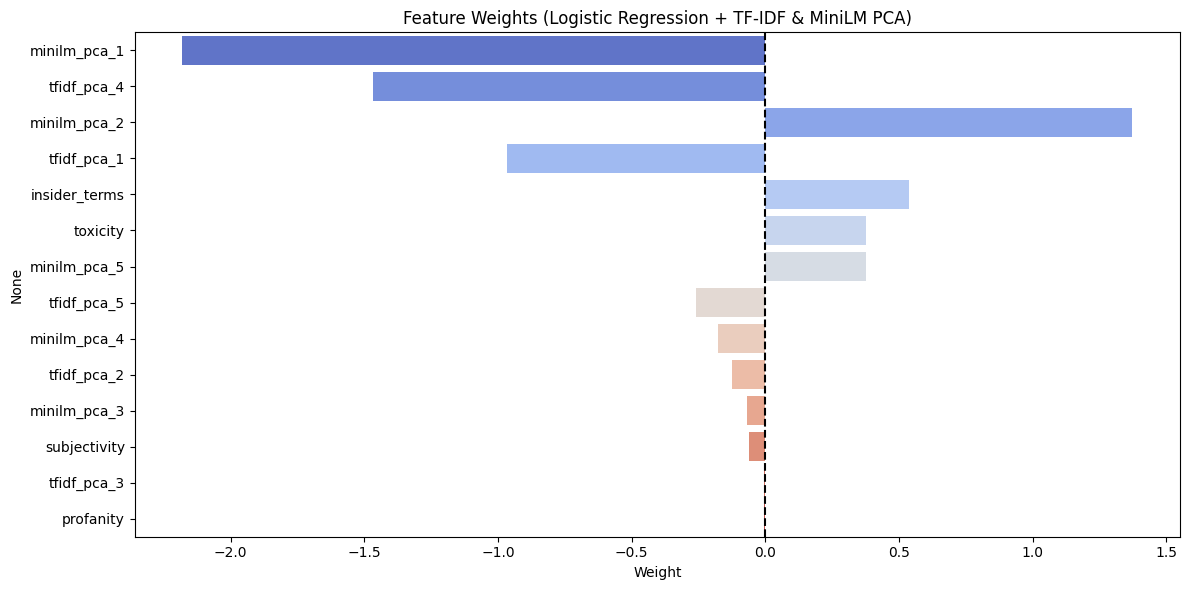

minilm_pca_1    -2.180959
tfidf_pca_4     -1.468005
minilm_pca_2     1.373784
tfidf_pca_1     -0.967393
insider_terms    0.537660
toxicity         0.378280
minilm_pca_5     0.376707
tfidf_pca_5     -0.257665
minilm_pca_4    -0.175295
tfidf_pca_2     -0.122484
minilm_pca_3    -0.068955
subjectivity    -0.062203
tfidf_pca_3     -0.005046
profanity       -0.004130
dtype: float64

In [12]:
# Check correlation of features on binary scale (0 - 1)
check_feature_correlations_pca(df)